# Определение стоимости автомобилей

# Determining the cost of cars

## Оглавление
- [Шаг 0. Описание проекта.](#Step_1)
- [Шаг 1. Подготовка данных.](#Step_2)
[Пункт 1.1. Изучение файлов.](#Step_3) <br />
[Пункт 1.2. Обработка данных.](#Step_4) <br />
- [Шаг 2. Обучение моделей.](#Step_5)<br />
[Пункт 2.1. Регрессия.](#Step_6) <br />
[Пункт 2.2. Случайный лес.](#Step_7) <br />
[Пункт 2.3. Градиентный бустинг.](#Step_8) <br />
- [Шаг 3. Анализ моделей.](#Step_9)<br />
[Пункт 3.1. Регрессия.](#Step_10) <br />
[Пункт 3.2. Случайный лес.](#Step_11) <br />
[Пункт 3.3. Градиентный бустинг.](#Step_12) <br />

## Table of contents
- [Step 0. Description of the project.](#Step_1)
- [Step 1. Data preparation.](#Step_2)
[Clause 1.1. Examining files.](#Step_3) <br />
[Clause 1.2. Data processing.](#Step_4) <br />
- [Step 2. Train models.](#Step_5)<br />
[Clause 2.1. Regression.](#Step_6) <br />
[Clause 2.2. Random forest.](#Step_7) <br />
[Clause 2.3. Gradient boosting.](#Step_8) <br />
- [Step 3. Model analysis.](#Step_9)<br />
[Clause 3.1. Regression.](#Step_10) <br />
[Clause 3.2. Random forest.](#Step_11) <br />
[Clause 3.3. Gradient boosting.](#Step_12) <br />

<a id='Step_1'></a>
Необходимо построить модель, сопосбную предсказать стоимость автомобиля, на основе его параметров. Нам доступны исторические данные. Эта модель будет использована в приложении сервиса по продаже автомобилей с пробегом. 

В этом проекте важны: качество предсказайний, их скорость и время обучения.

It is necessary to build a model capable of predicting the cost of a car based on its parameters. We have historical data available. This model will be used in the application of the service for the sale of used cars.

In this project, the quality of predictions, their speed and training time are important.

<a id='Step_2'></a>
# 1. Подготовка данных

# 1. Data preparation

<a id='Step_3'></a>
## 1.1. Изучение данных.

## 1.1. Data exploration.

Загрузка библиотек.

Loading libraries.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import itertools
from sklearn.preprocessing import StandardScaler

Загрузка файла.

Loading libraries.

In [ ]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

Пропуски:

Passes:

In [ ]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Описание переменных.

Description of variables.

In [ ]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


<a id='Step_4'></a>
## 1.2. Обработка данных.

## 1.2. Data processing.

Приведем DateCrawled, DateCreated и LastSeen к формату даты.

Let's cast DateCrawled, DateCreated and LastSeen to date format.

In [ ]:
df['DateCrawled'] = pd.to_datetime(df.DateCrawled, format='%Y-%m-%d %H:%M:%S')
df['DateCreated'] = pd.to_datetime(df.DateCreated, format='%Y-%m-%d %H:%M:%S')
df['LastSeen'] = pd.to_datetime(df.LastSeen, format='%Y-%m-%d %H:%M:%S')

Посмотрим на распредление месяцев регистрации. 

Let's look at the distribution of registration months.

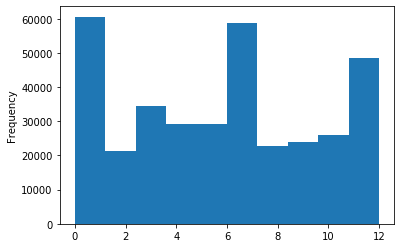

In [ ]:
df['RegistrationMonth'].plot(kind='hist')

Я думаю, что было бы размумно недопустимое значение 0 превартаить в числа от 1 до 12 в соответсвии с текущим распределением. То есть, если значение 2 встречается в 10% случаев, то мы 10% нулей превратим в 2. Но я не знаю как это сделать и нужно ли это. Поэтому я щаменю 0 на 1). По рекомендации просто удалил такие значения

I think it would be sensible to change the invalid value 0 into numbers from 1 to 12 according to the current distribution. That is, if the value 2 occurs in 10% of cases, then we will turn 10% of zeros into 2. But I don’t know how to do this and whether it is necessary. Therefore, I will reduce 0 to 1). As recommended, just removed such values

In [ ]:
df.drop(df[df['RegistrationMonth'] == 0].index, axis=0, inplace=True)

Исходя из знания, что автомобили не выпускались ранее 1886 года и из предположения, что год регистрации автомобиля не может быть позже даты его появления на сайте, удалим такие наблюдения.

Based on the knowledge that cars were not produced before 1886 and on the assumption that the year of registration of the car cannot be later than the date of its appearance on the site, we will remove such observations.

In [ ]:
df.drop(df[(df.RegistrationYear < 1886) | (df.RegistrationYear > pd.DatetimeIndex(df['DateCreated']).year)].index, axis=0,
       inplace=True)

Создадим признак RegistrationDate, который объеденит в себе месяц и дату регистрации авто.

Let's create the RegistrationDate feature, which will combine the month and date of registration of the car.

In [ ]:
df['RegistrationDate'] = df.RegistrationMonth.astype('str') + '.' + df.RegistrationYear.astype('str')
df['RegistrationDate'] = pd.to_datetime(df.RegistrationDate, format='%m.%Y')

Удалим наблюдения, в которых цена меньше 500. Наверно, маловероятно найти такой авто.

Let's remove the observations in which the price is less than 500. Probably, it is unlikely to find such a car.

In [ ]:
df.drop(df[df['Price'] < 500].index, axis=0, inplace=True)

Удалим наблюдения, в которых мощность равно 4,2 (самый слабый авто) или же более 1900 л.с. (самый мощный серийный авто).

Let's remove the observations in which the power is 4.2 (the weakest car) or more than 1900 hp. (the most powerful serial car).

In [ ]:
df.drop(df[(df['Power'] <= 4.2) | (df['Power'] > 1900)].index, axis=0, inplace=True)

Заполним Model 'other', так как пользователь может продовать редкий автомобиль, которого нет в базе сайта.

Let's fill in Model 'other', as the user can sell a rare car that is not in the site database.

In [ ]:
df['Model'].fillna('other', inplace=True)

Заполним VehicleType, Gearbox, FuelType unknown.

Fill in VehicleType, Gearbox, FuelType unknown.

In [ ]:
df['VehicleType'].fillna('unknown', inplace=True)

In [ ]:
df['Gearbox'].fillna('unknown', inplace=True)

In [ ]:
df['FuelType'].fillna('unknown', inplace=True)

Зоплним пропуски в NotRepaired 'no', предпологая, что чаще всего авто всё же не были в значительном ремонте. 

Let's fill in the gaps in Not Repaired 'no', assuming that more often than not the cars have not been significantly repaired.

In [ ]:
df['NotRepaired'].fillna('no', inplace=True)

Добавим признак Old (возраст авто). Вычтем из даты создания анкеты дату регистрации.

Let's add the sign Old (age of the car). Subtract the date of registration from the date of creation of the questionnaire.

In [ ]:
df['Old'] = (df['DateCreated'] - df['RegistrationDate']).apply(lambda x: x.days)

Удалим отрицательные значения, так как не верим в авто из будующего.

Let's remove negative values, because we don't believe in cars from the future.

In [ ]:
df.drop(df[df['Old'] < 0].index, axis=0, inplace=True)

Добавим признак TimeSell (время продажи). Вычтем из даты последней активности дату активации анкеты.

Let's add the attribute TimeSell (time of sale). Subtract the date of activation of the questionnaire from the date of the last activity.

In [ ]:
df['TimeSell'] = (df['LastSeen'] - df['DateCreated']).apply(lambda x: x.days)

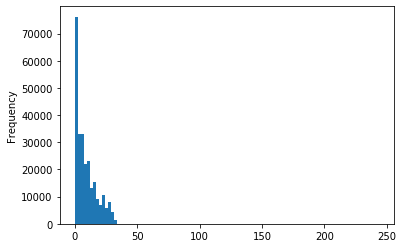

In [ ]:
df['TimeSell'].plot(kind='hist', bins=100)

In [ ]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode,Old,TimeSell
count,262221.000000,262221.000000,262221.000000,262221.000000,262221.000000,262221.0,262221.000000,262221.000000,262221.000000
mean,5276.514646,2003.056761,124.157680,127202.397977,6.378314,0.0,51604.603243,4644.029002,9.040885
std,4649.998000,6.267272,61.072439,37096.460023,3.351297,0.0,25719.298461,2290.789756,8.617648
min,500.000000,1910.000000,5.000000,5000.000000,1.000000,0.0,1067.000000,0.000000,0.000000
25%,1650.000000,1999.000000,82.000000,125000.000000,3.000000,0.0,31224.000000,3088.000000,2.000000
50%,3650.000000,2004.000000,116.000000,150000.000000,6.000000,0.0,50858.000000,4472.000000,6.000000
75%,7500.000000,2007.000000,150.000000,150000.000000,9.000000,0.0,72358.000000,5944.000000,14.000000
max,20000.000000,2016.000000,1900.000000,150000.000000,12.000000,0.0,99998.000000,38692.000000,244.000000


Посмотрим на распредление времени продажи.

Let's look at the distribution of sales time.

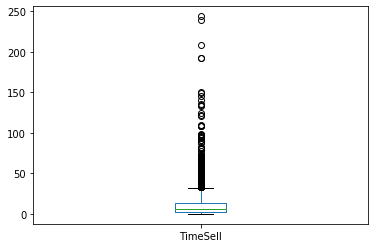

In [ ]:
df['TimeSell'].plot(kind='box')

Люди по-разному видят справедлвивую цену на свой авто, но немногие готовы купить авто по завышенной цене. Также продать машину в день публикации обявления - слишком быстро, вряд ли такие авто продавались по рыночным ценам. Удалим наблюдения,в которых время продажи равно 0 или выше суммы интерквартильного размаха умноженного на полтора и третей квартили. 

People see a fair price for their car in different ways, but few are willing to buy a car at an inflated price. Also, selling a car on the day the announcement was published is too fast, it is unlikely that such cars were sold at market prices. Let's remove observations where the sell time is 0 or greater than the sum of the interquartile range multiplied by one and a half and third quartiles.

In [ ]:
up_edge = df['TimeSell'].quantile(0.75) + (df['TimeSell'].quantile(0.75)-
                                           df['TimeSell'].quantile(0.25)) * 1.5
df.drop(df[(df['TimeSell'] == 0) & (df['TimeSell'] > up_edge)].index, axis=0, inplace=True)

Создадим перменную Car, которая будет содержать в себе и бренд и модель.

Let's create a Car variable that will contain both brand and model.

In [ ]:
df['Car'] = df['Brand'] + ' ' + df['Model']

Удалим столбцы.
- NumberOfPictures. Содержит только 0, удалим этот столбец.
- DateCrawled. Нам не нужно информация из него. 
- RegistrationYear и RegistrationMonth (так как мы сделали из них RegistrationDate)
- RegistrationDate, LastSeen,  и DateCreated, так как мы уже использовали их для создания Old и TimeSell.
- TimeSell, так как мы уже отчистили наблюдения по этому признаку.
- Brand, Model, так как мы сделали из них Car.
- PostalCode, так без знания страны или без базы кодов это информация бесполезна. Хотя на самом деле она содержит в себе информацию о регионе продажи авто.

Let's remove the columns.
- NumberOfPictures. Contains only 0, delete this column.
- datecrawled. We don't need information from it.
- RegistrationYear and RegistrationMonth (since we made RegistrationDate out of them)
- RegistrationDate, LastSeen, and DateCreated, since we already used them to create Old and TimeSell.
- TimeSell, since we have already cleared observations for this feature.
- Brand, Model, since we made Car out of them.
- PostalCode, so without knowing the country or without a codebase, this information is useless. Although in fact it contains information about the region where the car is sold.

In [ ]:
df.drop(['NumberOfPictures', 'DateCrawled', 'RegistrationYear', 'RegistrationMonth', 'LastSeen', 
         'RegistrationDate', 'DateCreated', 'Brand', 'Model', 'PostalCode', 'TimeSell']
        , axis=1, inplace=True)

Удалим дубликаты, если есть.

Remove duplicates, if any.

In [ ]:
df.drop_duplicates(inplace=True)

Восстановим индексы.

Let's restore the indexes.

In [ ]:
df.reset_index(inplace=True, drop=True)

Посомтрим на результат.

Let's look at the result.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251175 entries, 0 to 251174
Data columns (total 9 columns):
Price          251175 non-null int64
VehicleType    251175 non-null object
Gearbox        251175 non-null object
Power          251175 non-null int64
Kilometer      251175 non-null int64
FuelType       251175 non-null object
NotRepaired    251175 non-null object
Old            251175 non-null int64
Car            251175 non-null object
dtypes: int64(4), object(5)
memory usage: 17.2+ MB


Закодируем перменные типа obj в дамми.

Let's encode obj-type variables into dummy.

In [ ]:
df = pd.get_dummies(df, drop_first=True)

Посмотрим на форму сета.

Let's look at the form of the set.

In [ ]:
df.shape

(251175, 318)

Разделим выборку на обучнеие и тест. На тест оставим треть наблюдений.

We divide the sample into training and test. Let's leave a third of the observations for the test.

In [ ]:
X = df.drop(['Price'], axis=1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Отнормируетм обучение и тест.

Let's normalize training and test.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['Power', 'Kilometer', 'Old']])
X_train = np.hstack((X_train_scaled, np.array(X_train.drop(['Power', 'Kilometer', 'Old'], axis=1))))
X_test_scaled = scaler.transform(X_test[['Power', 'Kilometer', 'Old']])
X_test = np.hstack((X_test_scaled, np.array(X_test.drop(['Power', 'Kilometer', 'Old'], axis=1))))

### Summary.
На этом этапе мы изучили данные и привели их к нужному состоянию:
- удалили дубликаты и подозрительные наблюдения
- выяснили возраст машин и срок их продажи
- изменили форматы данных
- разделили выборку на обучение и тест.

### Summary.
At this stage, we have studied the data and brought it to the desired state:
- removed duplicates and suspicious observations
- found out the age of the cars and the period of their sale
- changed data formats
- Divided the sample into training and test.

<a id='Step_5'></a>
# 2. Обучение моделей

#2 Train Models

Определим фунцию потерь для кросс-валидации.

Let's define the loss function for cross-validation.

In [ ]:
MSE = make_scorer(mean_squared_error, greater_is_better=False)

<a id='Step_6'></a>
## 2.1. Регрессия. 

## 2.1. Regression.

In [ ]:
model_l_r = Ridge()
parameters_l_r = {'fit_intercept':(True, False), 'alpha':(1, 10)}
clf_l_r = GridSearchCV(model_l_r, parameters_l_r, cv=2, scoring=MSE)
clf_l_r.fit(X_train, y_train)
print('Лучшие переметры:', clf_l_r.best_params_)

Лучшие переметры: {'alpha': 1, 'fit_intercept': True}


Best parameters: {'alpha': 1, 'fit_intercept': True}

<a id='Step_7'></a>
## 2.2. Случайный лес. 

## 2.2. Random forest.

In [ ]:
model_l_r = RandomForestRegressor()
parameters_l_r = {'max_depth':(1, 20), 'n_estimators':(1, 20)}
clf_l_r = GridSearchCV(model_l_r, parameters_l_r, cv=2, scoring=MSE)
clf_l_r.fit(X_train, y_train)
print('Лучшие переметры:', clf_l_r.best_params_)

Лучшие переметры: {'max_depth': 20, 'n_estimators': 20}


Best parameters: {'max_depth': 20, 'n_estimators': 20}

<a id='Step_8'></a>
## 2.3. Градиентный бустинг. 

## 2.3. Gradient boosting.

In [ ]:
model_l_r = LGBMRegressor()
parameters_l_r = {'learning_rate':(0.1, 0.3, 0.5, 0.7), 'reg_lambda':(0, 5, 50)}
clf_l_r = GridSearchCV(model_l_r, parameters_l_r, cv=2, scoring=MSE)
clf_l_r.fit(X_train, y_train)
print('Лучшие переметры:', clf_l_r.best_params_)

Лучшие переметры: {'learning_rate': 0.5, 'reg_lambda': 5}


Best parameters: {'learning_rate': 0.5, 'reg_lambda': 5}

### Summary.
На этом этапе мы подобрали параметры для моделей. На следующем этапе проанализируем эти модели с нужными параметрами

### Summary.
At this stage, we selected the parameters for the models. At the next stage, we analyze these models with the required parameters.

<a id='Step_9'></a>
# 3. Анализ моделей

# 3. Model analysis

<a id='Step_10'></a>
## 3.1. Регрессия. 

## 3.1. Regression.

Скорость обучения.

Learning rate.

In [ ]:
%%time
model_r = Ridge(fit_intercept=True, alpha=1)
model_r.fit(X_train, y_train)

CPU times: user 2 s, sys: 711 ms, total: 2.71 s
Wall time: 2.7 s


Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

Скорость предсказания и точность.

Prediction speed and accuracy.

In [ ]:
%%time
prediction = model_r.predict(X_test)
rMSE = mean_squared_error(prediction, y_test) ** 0.5
print(rMSE)

2686.468989043734
CPU times: user 72.8 ms, sys: 69.7 ms, total: 142 ms
Wall time: 115 ms


<a id='Step_11'></a>
## 3.2. Случайный лес. 

## 3.2. Random forest.

Скорость обучения.

Learning rate.

In [ ]:
%%time
model_f = RandomForestRegressor(max_depth=20, n_estimators=20, random_state=0)
model_f.fit(X_train, y_train)

CPU times: user 1min 13s, sys: 58.3 ms, total: 1min 13s
Wall time: 1min 13s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

Скорость предсказания и точность.

Prediction speed and accuracy.

In [ ]:
%%time
prediction = model_f.predict(X_test)
rMSE = mean_squared_error(prediction, y_test) ** 0.5
print(rMSE)

1665.0848628671024
CPU times: user 645 ms, sys: 28 ms, total: 673 ms
Wall time: 688 ms


<a id='Step_12'></a>
## 3.3. Градиентный бустинг. 

## 3.3. Gradient boosting.

Скорость обучения.

Learning rate.

In [ ]:
%%time
model_l = LGBMRegressor(learning_rate=0.5, reg_lambda=0, random_state=0)
model_l.fit(X_train, y_train)

CPU times: user 7.35 s, sys: 173 ms, total: 7.52 s
Wall time: 7.54 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.5, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=0, reg_alpha=0.0, reg_lambda=0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Скорость предсказания и точность.

Prediction speed and accuracy.

In [ ]:
%%time
prediction = model_l.predict(X_test)
rMSE = mean_squared_error(prediction, y_test) ** 0.5
print(rMSE)

1620.5267878428092
CPU times: user 927 ms, sys: 61 ms, total: 988 ms
Wall time: 916 ms


### Summary.
- Самое быстрое обучение - регрессия (3.39 s Wall time)
- Самое быстрое предсказание - регрессия (59.1 ms Wall time)
- Наилучший результат метрики rMSE - LGBM (1614.66 евро).

### Summary.
- Fastest learning - regression (3.39 s Wall time)
- Fastest prediction - regression (59.1 ms Wall time)
- The best result of the rMSE metric is LGBM (1614.66 euros).

### Общий вывод.
В этом проекте:
- мы изучили и подготовили данные (произвели отчистку от подохрительных наблюдений, изменили форматы переменных и создали новые признаки)
- подобрали параметры для моделей регрессии, случайного леса и градиентного бустинга.
- проанализировали модели и получили результаты, которые описаны ниже.

### General conclusion.
In this project:
- we studied and prepared the data (cleaned up suspicious observations, changed the formats of variables and created new features)
- selected parameters for regression, random forest and gradient boosting models.
- analyzed the models and obtained the results, which are described below.

### Рекомендация по выбору модели. 
Несмотря на то, что скорость обучения и предсказания оказалась ниже у регрессии, мы рекомендуем использовать именно LGBMRegression, так как скорость работы модели всё же вполне приемлема (обучение - 7.78 s Wall time, предсказание - 900 ms Wall time). Кроме того, бустинг показывает лучшую метрику rMSE - 1614.66 против 2694.37 у регрессии, что заметного меньше. Случайный лес хоть и приближается по качеству к LGBM - 1659.86, но всё же занимает значитально больше врмени (обучение - 1min 55s Wall time, предсказание - 626 ms Wall time).

### Model recommendation.
Despite the fact that the learning and prediction speed turned out to be lower for the regression, we recommend using LGBMRegression, since the speed of the model is still quite acceptable (training - 7.78 s Wall time, prediction - 900 ms Wall time). In addition, boosting shows the best rMSE metric - 1614.66 versus 2694.37 for the regression, which is less noticeable. Although Random Forest is close in quality to LGBM - 1659.86, it still takes much more time (training - 1min 55s Wall time, prediction - 626 ms Wall time).